In [ ]:
# --- Standard Library ---
import sys
import os

project_root = '/d/hpc/projects/FRI/jf73497/aimi-project/src/segformer3duls/'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import random
import yaml

# --- Third-Party Libraries ---
import numpy as np
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
from termcolor import colored
from accelerate import Accelerator
from scipy.ndimage import (
    binary_closing,
    binary_opening,
    binary_dilation,
    binary_erosion,
    generate_binary_structure
)

# --- Local Imports ---
#sys.path.append("..")

from dataloaders.build_dataset import build_dataset, build_dataloader
from architectures.build_architecture import build_architecture
from metrics.competition_metric import ULS23_evaluator

# CSV paths are relative to the experiment directory, 
# so we change the working directory to the experiment directory.
os.chdir(project_root+"experiments/uls_2023/dice_oversampled_experiment/")

/d/hpc/projects/FRI/jf73497/aimi-project/src/segformer3duls/venv_segformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(torch.cuda.is_available())
os.chdir(project_root+"experiments/uls_2023/dice_oversampled_experiment/")

True


In [4]:
def test_time_dilation(input_tensor):
    # Convert to NumPy and squeeze batch and channel dimensions
    volume = input_tensor.squeeze().cpu().numpy()
    
    # Apply binary dilation
    dilated = binary_dilation(volume, structure=np.ones((3, 3, 3)))

    return dilated.astype(np.uint8)

def test_time_2xdilation(input_tensor):
    volume = input_tensor.squeeze().cpu().numpy()
    
    # Apply binary dilation twice
    dilated = binary_dilation(volume, structure=np.ones((3, 3, 3)))
    dilated = binary_dilation(dilated, structure=np.ones((3, 3, 3)))

    return dilated.astype(np.uint8)

def test_time_opening(input_tensor):
    volume = input_tensor.squeeze().cpu().numpy()
    
    # Apply binary opening: erosion followed by dilation
    opened = binary_erosion(volume, structure=np.ones((3, 3, 3)))
    opened = binary_dilation(opened, structure=np.ones((3, 3, 3)))

    return opened.astype(np.uint8)

def test_time_closing(input_tensor):
    volume = input_tensor.squeeze().cpu().numpy()
    
    # Apply binary closing: dilation followed by erosion
    closed = binary_dilation(volume, structure=np.ones((3, 3, 3)))
    closed = binary_erosion(closed, structure=np.ones((3, 3, 3)))

    return closed.astype(np.uint8)

def test_time_shift(model, input_tensor, threshold=0.5):
    predictions = []

    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)

    shifts = [
        (0, 0, 0),
        (5, 0, 0), 
        # (-5, 0, 0),
        # (0, 5, 0), 
        (0, -5, 0),
        # (0, 0, 5), 
        (0, 0, -5),
    ]

    with torch.no_grad():
        for dz, dx, dy in shifts:
            augmented = input_tensor.clone()

            # Shift
            augmented = torch.roll(augmented, shifts=(dz, dx, dy), dims=(2, 3, 4))

            # Model inference
            logits = model.forward(augmented)
            logits = logits[:, 1:, ...]
            pred = torch.sigmoid(logits[:, :, ...])
            pred = pred > 0.5

            # Undo shift
            pred = torch.roll(pred, shifts=(-dz, -dx, -dy), dims=(2, 3, 4))
            predictions.append(pred.float())

    avg_prediction = torch.stack(predictions).mean(dim=0, keepdims=True)

    # --- Morphological smoothing ---
    # Convert to NumPy for processing
    pred_np = avg_prediction.squeeze().cpu().numpy()

    # Binarize
    binary_pred = pred_np > threshold
    return binary_pred

In [6]:
evaluator = ULS23_evaluator()

def load_config(config_path: str):
    """loads the yaml config file

    Args:
        config_path (str): _description_

    Returns:
        Dict: _description_
    """
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config

##################################################################################################
def seed_everything(config) -> None:
    seed = config["training_parameters"]["seed"]
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def load_checkpoint(
        config,
        accelerator,
):
    accelerator.load_state(
        config["training_parameters"]["load_checkpoint"]["load_checkpoint_path"]
    )
   

def _run_eval(accelerator, model, val_dataloader) -> None:
    """_summary_"""
    # Tell wandb to watch the model and optimizer values

    accelerator.print("[info] -- Starting model evaluation")

    # Initialize the training loss for the current Epoch
    original_dice_total = 0.0
    original_uls_metric_total = 0.0

    dilated_uls_metric_total = 0.0

    dilatedx2_uls_metric_total = 0.0

    opening_uls_metric_total = 0.0

    closing_uls_metric_total = 0.0

    shift_uls_metric_total = 0.0


    # set model to train mode
    model.eval()

    ULS_per_threshold = [0.0]*9
    thresholds = np.linspace(0.1, 0.9, 9)
    
    with torch.no_grad():
        for index, (raw_data) in enumerate(tqdm(val_dataloader)):
            # get data ex: (data, target)
            data, labels = (
                raw_data["image"],
                raw_data["label"],
            )

            logits = model.forward(data)
            logits = logits[:, 1:, ...]
            predicted = torch.sigmoid(logits)

            for i, threshold in enumerate(thresholds):
                y_pred = predicted > threshold
                y_true = labels[:, 1:, ...]

                ULS_per_threshold[i] += evaluator.ULS_score_metric(y_pred, y_true)

    ULS_per_threshold = np.array(ULS_per_threshold)/float(index + 1)
    best_index = np.argmax(ULS_per_threshold)
    best_threshold = thresholds[best_index]


    # set epoch to shift data order each epoch
    # self.val_dataloader.sampler.set_epoch(self.current_epoch)
    with torch.no_grad():
        for index, (raw_data) in enumerate(tqdm(val_dataloader)):
            # get data ex: (data, target)
            data, labels = (
                raw_data["image"],
                raw_data["label"],
            )

            logits = model.forward(data)
            logits = logits[:, 1:, ...]
            predicted = torch.sigmoid(logits)
            y_pred = predicted > best_threshold
            y_true = labels[:, 1:, ...]

            original_uls_metric_total += evaluator.ULS_score_metric(y_pred, y_true)
            # print(f"Orgi ULS: {original_uls_metric}")

            # Test-time dilation
            dilated_pred = test_time_dilation(y_pred.float())
            dilated_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(dilated_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )

            # Test-time 2x dilation
            dilatedx2_pred = test_time_2xdilation(y_pred.float())
            dilatedx2_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(dilatedx2_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )

            # Test-time opening
            opened_pred = test_time_opening(y_pred.float())
            opening_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(opened_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )

            # Test-time closing
            closed_pred = test_time_closing(y_pred.float())
            closing_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(closed_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )

            # Test-time shift
            shifted_pred = test_time_shift(model, data, threshold=best_threshold)
            shift_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(shifted_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )


            # y_pred = test_time_augmentation(model, data, morph_op='opening')
            # my_uls_metric = evaluator.ULS_score_metric(y_pred, y_true)
            # print(f"My ULS: {my_uls_metric}")
            


            # # calculate metrics
            # if self.calculate_metrics:
            #     mean_dice, mean_uls_metric = self._calc_dice_metric(data, labels, use_ema)
            #     # keep track of number of total correct
            #     total_dice += mean_dice
            #     total_uls_metric += mean_uls_metric

            #     my_total_uls_metric += my_uls_metric

            # update loss for the current batch
            # epoch_avg_loss += loss.item()

    # Average across batches
    divisor = float(index + 1)
    original_uls_metric_total /= divisor
    dilated_uls_metric_total /= divisor
    dilatedx2_uls_metric_total /= divisor
    opening_uls_metric_total /= divisor
    closing_uls_metric_total /= divisor
    shift_uls_metric_total /= divisor


    # Print metrics
    accelerator.print(
        f"Original ULS: {colored(f'{original_uls_metric_total:.5f}', 'green')} | "
        f"Dilated: {colored(f'{dilated_uls_metric_total:.5f}', 'cyan')} | "
        f"2x Dilated: {colored(f'{dilatedx2_uls_metric_total:.5f}', 'cyan')} | "
        f"Opening: {colored(f'{opening_uls_metric_total:.5f}', 'cyan')} | "
        f"Closing: {colored(f'{closing_uls_metric_total:.5f}', 'cyan')} | "
        f"Shifted: {colored(f'{shift_uls_metric_total:.5f}', 'cyan')}"
    )

    return ULS_per_threshold



In [8]:
os.getcwd()

'/d/hpc/projects/FRI/jf73497/aimi-project/src/segformer3duls/experiments/uls_2023/dice_oversampled_experiment'

In [9]:
# load config
config = load_config("/d/hpc/home/jf73497/projects/aimi-project/src/tta_aug/config.yaml")

# set seed
seed_everything(config)

# build validation dataset & validataion data loader
valset = build_dataset(
    dataset_type=config["dataset_parameters"]["dataset_type"],
    dataset_args=config["dataset_parameters"]["val_dataset_args"],
)
valloader = build_dataloader(
    dataset=valset,
    dataloader_args=config["dataset_parameters"]["val_dataloader_args"],
    config=config,
    train=False,
)

# build the Model
model = build_architecture(config)


# use accelarate
accelerator = Accelerator(
    log_with="wandb",
    gradient_accumulation_steps=config["training_parameters"][
        "grad_accumulate_steps"
    ],
)
# accelerator.init_trackers(
#     project_name=config["project"],
#     config=config,
#     init_kwargs={"wandb": config["wandb_parameters"]},
# )


# convert all components to accelerate
model = accelerator.prepare_model(model=model)
valloader = accelerator.prepare_data_loader(data_loader=valloader)

if config["training_parameters"]["load_checkpoint"]["load_full_checkpoint"]:
        print("[info] -- Loading checkpoint.")
        load_checkpoint(
            config=config,
            accelerator=accelerator,)

print("[info] -- Running evaluation only.")
ULS_per_threshold = _run_eval(accelerator, model, valloader)

Initializing dataset with csv file:  ../../../data/uls2023_oversampled_seg/validation.csv
Number of samples:  201
Loaded ULS2023 dataset
[info] -- Loading checkpoint.
[info] -- Running evaluation only.
[info] -- Starting model evaluation


100%|██████████| 201/201 [08:21<00:00,  2.49s/it]

Original ULS: 0.51879 | Dilated: 0.43515 | 2x Dilated: 0.34632 | Opening: 0.47587 | Closing: 0.51864 | Shifted: 0.46661


In [12]:
print(ULS_per_threshold)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001DB7FF4E0E0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 1db11480580, raw_cell="print(ULS_per_threshold)" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Lazar/OneDrive/Desktop/RU%20Courses/AI%20in%20Medical%20Imaging/project/aimi-project/SegFormer3D-main/tta_aug/tta_preprocessed.ipynb#X11sZmlsZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

[0.55682154 0.55853287 0.5591937  0.55975669 0.56031297 0.56064882
 0.56097877 0.5611234  0.56077012]
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001DB7FF4E0E0>> (for post_run_cell), with arguments args (<ExecutionResult object at 1db114775b0, execution_count=12 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1db11480580, raw_cell="print(ULS_per_threshold)" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Lazar/OneDrive/Desktop/RU%20Courses/AI%20in%20Medical%20Imaging/project/aimi-project/SegFormer3D-main/tta_aug/tta_preprocessed.ipynb#X11sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001DB7FF4E0E0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 1db114f77f0, raw_cell="import numpy as np
import seaborn as sns
import ma.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Lazar/OneDrive/Desktop/RU%20Courses/AI%20in%20Medical%20Imaging/project/aimi-project/SegFormer3D-main/tta_aug/tta_preprocessed.ipynb#W4sZmlsZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

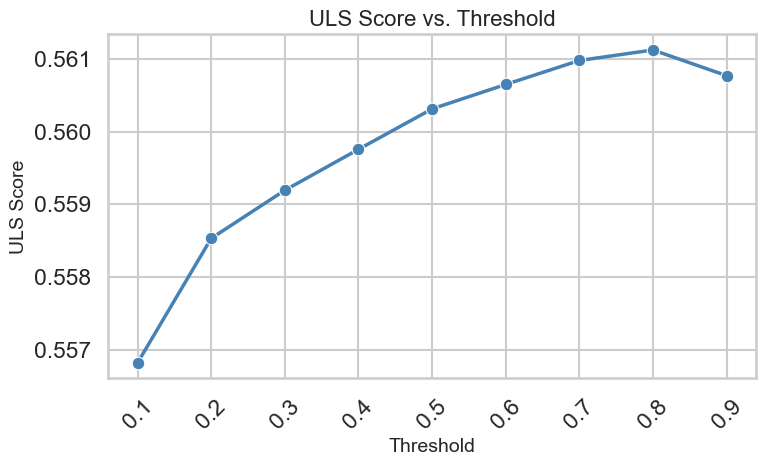

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001DB7FF4E0E0>> (for post_run_cell), with arguments args (<ExecutionResult object at 1db202772e0, execution_count=13 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 1db114f77f0, raw_cell="import numpy as np
import seaborn as sns
import ma.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Lazar/OneDrive/Desktop/RU%20Courses/AI%20in%20Medical%20Imaging/project/aimi-project/SegFormer3D-main/tta_aug/tta_preprocessed.ipynb#W4sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
thresholds = np.linspace(0.1, 0.9, 9)

# Set seaborn style
sns.set_theme(style="whitegrid", context="talk")

# Create the plot
plt.figure(figsize=(8, 5))
sns.lineplot(x=thresholds, y=ULS_per_threshold, marker="o", linewidth=2.5, color="steelblue")

# Labels and title
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("ULS Score", fontsize=14)
plt.title("ULS Score vs. Threshold", fontsize=16)
plt.xticks(thresholds, rotation=45)
# plt.ylim(0, 1)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()